# **Рекомендатнльная система фильмов (разбор методов):**


In [83]:
#если нужно, то устанавливаем пакеты

#!pip install surprise
#!pip install -U scikit-learn

In [53]:
import numpy as np 
from numpy import nan
import pandas as pd 
from matplotlib import pyplot as plt

In [54]:
data_movie = pd.read_csv('movie.csv')
data_rating = pd.read_csv('rating.csv')
data_tag = pd.read_csv('tag.csv')

In [55]:
data_rating = pd.merge(data_movie[['movieId','title']],data_rating)

## Обрабатываем данные для контентной фильтрации

In [56]:
df = data_tag.groupby("movieId")['tag'].agg(lambda x: set(x)).reset_index()

In [57]:
df['metadata'] = df['tag'].str.join(", ")

In [58]:
df

,movieId,tag,metadata
0,1,"{comedy, fantasy, action figures, cgi, voice a...","comedy, fantasy, action figures, cgi, voice ac..."
1,2,"{see also:Zathura, fantasy, Kirsten Dunst, tim...","see also:Zathura, fantasy, Kirsten Dunst, time..."
2,3,"{sequel fever, comedy, sequel, comedinha de ve...","sequel fever, comedy, sequel, comedinha de vel..."
3,4,"{revenge, chick flick, characters, CLV}","revenge, chick flick, characters, CLV"
4,5,"{family, sequel fever, sequel, Steve Martin, w...","family, sequel fever, sequel, Steve Martin, we..."
...,...,...,...
19540,131054,{dinosaurs},dinosaurs
19541,131082,"{documentary, Yoshitomo Nara}","documentary, Yoshitomo Nara"
19542,131164,{Vietnam War},Vietnam War
19543,131170,{alternate reality},alternate reality


Пропущенных значений нет

In [59]:
data_item = pd.merge(data_movie,df.drop(columns = 'tag'), how = 'outer')

У некоторых фильмов отсутствует метадата, заполним такие No tag

In [60]:
data_item['metadata']= data_item['metadata'].fillna('No tag')

In [61]:
data_item

,movieId,title,genres,metadata
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"comedy, fantasy, action figures, cgi, voice ac..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"see also:Zathura, fantasy, Kirsten Dunst, time..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"sequel fever, comedy, sequel, comedinha de vel..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"revenge, chick flick, characters, CLV"
4,5,Father of the Bride Part II (1995),Comedy,"family, sequel fever, sequel, Steve Martin, we..."
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,No tag
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,No tag
27275,131258,The Pirates (2014),Adventure,"mutiny, whale, bandits, Korea, pirates"
27276,131260,Rentun Ruusu (2001),(no genres listed),No tag


## Мутим User-Item матрицу


In [62]:
from scipy.sparse import csr_matrix

Из-за переполнения памяти возьмем лишь сэмпл данных


In [63]:
sub_rating = data_rating.sample(10000, random_state = 42).reset_index()

In [64]:
data_user_item = sub_rating.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)

In [65]:
data_user_item

userId,11,21,44,69,90,91,96,142,144,152,...,138301,138328,138355,138388,138404,138406,138426,138437,138464,138474
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Популярность

Топ по рейтингу. 

In [66]:
top_n = 10
pop_movies = data_rating.groupby('title').agg({'rating': 'sum'}).nlargest(top_n, 'rating')
pop_movies

,rating
title,
"Shawshank Redemption, The (1994)",281788.0
Pulp Fiction (1994),280967.5
Forrest Gump (1994),266607.0
"Silence of the Lambs, The (1991)",264403.5
Star Wars: Episode IV - A New Hope (1977),228400.0
Jurassic Park (1993),218840.0
Braveheart (1995),217363.0
Schindler's List (1993),215741.5
"Matrix, The (1999)",214945.0


## TF-IDF Vectorizer на основе метадаты


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data_item['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=data_item.index.tolist())
print(tfidf_df.shape)

(27278, 23851)


## TruncatedSVD

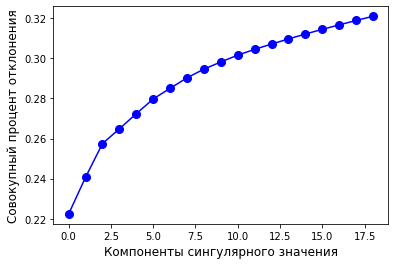

In [84]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)

explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='blue')
plt.xlabel('Компоненты сингулярного значения', fontsize= 12)
plt.ylabel('Совокупный процент отклонения', fontsize=12)        
plt.show()

In [69]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=data_item.title.tolist())

## Коллаборативная фильтрация

In [70]:
latent_matrix_2 = svd.fit_transform(data_user_item)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index= sub_rating.title.unique())

In [71]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Charley Varrick (1973),-3.411927e-02,7.752480e-02,-1.156821e-01,-2.991652e-02,-1.297936e-01,2.790074e-01,-4.257033e-02,2.019063e-01,6.611638e-01,9.369389e-01,-1.928974e+00,1.645234e+00,-8.636094e+00,1.685472e+01,-1.793850e-01,-7.627215e-02,-1.008778e+00,5.402110e-01,-1.103767e+00
Fried Green Tomatoes (1991),-5.528594e-05,3.105434e-04,-5.463128e-04,-2.238726e-04,-1.274995e-03,1.547353e-03,2.249931e-03,-4.560649e-04,2.913089e-03,5.727224e-04,1.301232e-03,-3.398735e-03,-4.908597e-03,-4.872071e-03,-3.375339e-03,3.819915e-03,6.385579e-03,3.353543e-03,-7.965842e-04
Ghost Dog: The Way of the Samurai (1999),1.504546e-04,-3.926604e-06,-1.848187e-04,7.098304e-04,8.806225e-05,-1.298704e-03,-1.688280e-03,-4.430836e-04,-1.342103e-03,3.799318e-04,-5.684690e-04,-1.504829e-04,-2.343963e-03,-1.891291e-03,-1.768489e-04,-7.329179e-04,-8.267661e-03,-5.925409e-03,2.517159e-03
The Count of Monte Cristo (2002),-6.746614e-07,9.258284e-07,7.110134e-07,-5.616548e-08,-5.330416e-06,4.691031e-06,2.184599e-06,2.135630e-06,6.350680e-07,4.250600e-06,-6.360220e-07,-8.002261e-06,-5.168794e-06,-1.161910e-05,-1.257384e-05,1.314094e-05,1.879117e-05,5.937428e-06,-2.039022e-05
"Shining, The (1980)",-1.691527e-04,-8.191046e-04,1.934738e-04,6.054494e-03,2.447141e-03,8.404210e-03,1.143478e-04,-1.223554e-02,-3.451675e-04,-4.323440e-03,6.704181e-04,-6.804366e-03,-1.367527e-02,-2.371822e-02,-1.848255e-02,6.330793e-03,-7.412827e-03,-1.027659e-02,1.340772e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Innerspace (1987),-8.713364e-11,3.576194e-11,1.623291e-10,-2.778859e-10,-1.883435e-10,2.737813e-10,-3.223334e-10,7.490675e-10,7.022254e-11,7.501589e-10,-6.749896e-10,-1.489646e-09,-4.737853e-10,-5.572683e-10,-1.500942e-09,-7.865202e-10,2.372847e-09,1.012093e-09,-2.317501e-09
"Bear, The (Ours, L') (1988)",-3.339363e-05,1.323434e-04,1.151457e-04,-2.233423e-04,-1.557951e-04,3.628912e-04,-6.971940e-04,3.432988e-04,2.498034e-04,2.947894e-04,8.100348e-04,-7.766789e-04,-1.245181e-03,6.942504e-04,-1.508499e-03,-1.351973e-03,-8.330519e-05,1.939412e-04,-2.411608e-03
Planet Terror (2007),1.988488e-07,-3.088688e-07,2.302954e-07,4.747726e-07,-9.173867e-08,-8.604522e-07,8.629533e-07,-2.797362e-06,1.482543e-06,1.194997e-06,1.245592e-06,2.125483e-07,2.344550e-07,3.047603e-06,-2.556481e-07,-2.540555e-06,2.184352e-06,-2.273312e-06,4.458835e-06
Lost & Found (1999),2.336406e-11,7.767519e-11,-1.505375e-11,-3.464001e-11,3.504269e-11,-1.434181e-11,5.913413e-10,2.119955e-10,-1.107328e-11,-2.672285e-10,3.271562e-10,-6.603145e-10,-3.245476e-10,5.698140e-10,-4.455348e-10,-5.180062e-11,1.097791e-09,-7.449259e-10,1.152627e-09


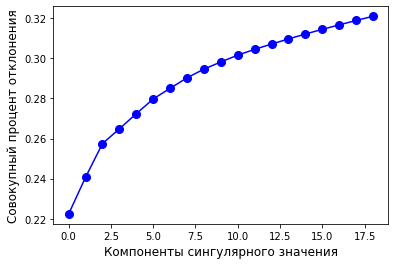

In [85]:
explained = svd.explained_variance_ratio_.cumsum()

plt.plot(explained, '.-', ms = 16, color='blue')
plt.xlabel('Компоненты сингулярного значения', fontsize= 12)
plt.ylabel('Совокупный процент отклонения', fontsize=12)        
plt.show()

In [73]:
from sklearn.metrics.pairwise import cosine_similarity

latent_matrix_1_df = latent_matrix_1_df[~latent_matrix_1_df.index.duplicated(keep='first')]
latent_matrix_2_df = latent_matrix_2_df[~latent_matrix_2_df.index.duplicated(keep='first')]
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)
score_1 = score_1[:score_2.shape[0]]

hybrid = ((score_2 + score_1)/2.0)


dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 

similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )


similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(20)

,content,collaborative,hybrid
Contraband (2012),0.958270,-0.635222,0.161524
"Punisher, The (2004)",0.955584,0.211696,0.583640
"Iron Giant, The (1999)",0.955168,-0.169205,0.392981
Tron (1982),0.949715,0.995991,0.972853
Out of Sight (1998),0.946264,0.020237,0.483251
"Avengers, The (2012)",0.944079,0.147133,0.545606
Anna and the King (1999),0.942851,0.589519,0.766185
The Fault in Our Stars (2014),0.941681,-0.145249,0.398216
Godzilla (Gojira) (1954),0.938418,0.020241,0.479330
Taxi 2 (2000),0.938273,0.169755,0.554014


In [74]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(20)

,content,collaborative,hybrid
Charade (1963),-7.851025e-07,0.996358,0.498178
Benny & Joon (1993),4.509483e-01,0.996212,0.723580
Field of Dreams (1989),1.611840e-01,0.995998,0.578591
Tron (1982),9.497154e-01,0.995991,0.972853
St. Elmo's Fire (1985),4.093679e-01,0.995990,0.702679
It Might Get Loud (2008),5.638513e-01,0.995990,0.779921
On the Town (1949),3.269715e-01,0.995495,0.661233
"Break-Up, The (2006)",-7.851025e-07,0.987598,0.493799
Murder on the Orient Express (1974),3.702041e-01,0.899359,0.634782
"Tree Grows in Brooklyn, A (1945)",4.704931e-01,0.875072,0.672783


In [75]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(20)

,content,collaborative,hybrid
Baby Face (1933),0.921668,0.742248,0.831958
Toy Story (1995),0.660195,1.000000,0.830097
Rescue Dawn (2006),0.761489,0.837691,0.799590
Lost & Found (1999),0.782228,0.814047,0.798137
"Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)",0.806746,0.781010,0.793878
"Little Mermaid, The (1989)",0.778154,0.785381,0.781767
It Might Get Loud (2008),0.563851,0.995990,0.779921
Old Boy (2003),0.710760,0.848269,0.779514
"Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997)",0.824231,0.718885,0.771558
"Clockwork Orange, A (1971)",0.883191,0.658870,0.771030


## Surprise

In [76]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [77]:
reader = Reader()
data = Dataset.load_from_df(sub_rating[['userId', 'movieId', 'rating']], reader)

In [78]:
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

accuracy.rmse(predictions)

RMSE: 1.0382


1.0382379382070923

## Гибридная модель

In [79]:
latent_matrix_1_df = latent_matrix_1_df[~latent_matrix_1_df.index.duplicated(keep='first')]
latent_matrix_2_df = latent_matrix_2_df[~latent_matrix_2_df.index.duplicated(keep='first')]

In [80]:
def hybrid_recommender(title):
    
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    score_1 = score_1[:score_2.shape[0]]

    hybrid = ((score_1 + score_2)/2.0)

    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(20))

In [82]:
hybrid_recommender('Brazil (1985)')

                                                     content  collaborative  \
Captain Corelli's Mandolin (2001)                   0.915955       0.704606   
Navigator: A Mediaeval Odyssey, The (1988)          0.827308       0.775907   
Sound of Music, The (1965)                          0.717232       0.785285   
Presidio, The (1988)                                0.695388       0.777264   
Auto Focus (2002)                                   0.800555       0.661282   
Limbo (1999)                                        0.699573       0.751317   
Blood and Wine (Blood & Wine) (1996)                0.896760       0.554096   
Con Air (1997)                                      0.801210       0.649348   
Airheads (1994)                                     0.853051       0.587721   
Bridges of Madison County, The (1995)               0.764098       0.672981   
Cove, The (2009)                                    0.657329       0.779355   
Madness of King George, The (1994)                  